In [66]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick

In [67]:
TICKER = 'SPY'

MFI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK):

    # get data at interval you want
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_MFI(df, length=14, overbought=80, oversold=20):
    df = df.copy()

    # Step 1: Calculate typical price
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Step 2: Calculate raw money flow
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']

    # Step 3: Classify positive/negative money flow
    df['Price_Change'] = df['Typical_Price'].diff()

    df['Pos_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    # Step 4: Money Flow Ratio and MFI
    pos_sum = df['Pos_Flow'].rolling(window=length).sum()
    neg_sum = df['Neg_Flow'].rolling(window=length).sum()
    mfr = pos_sum / neg_sum
    df['MFI'] = 100 - (100 / (1 + mfr))

    # Step 5: Plot
    plt.figure()
    plt.plot(df['MFI'], label='MFI')
    plt.axhline(overbought, color='red', linestyle='--', label='Overbought')
    plt.axhline(oversold, color='green', linestyle='--', label='Oversold')
    plt.title('Money Flow Index')
    plt.legend()
    plt.show()

    return df.dropna()


In [68]:
def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] < 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_MFI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['MFI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))
    return df

In [69]:
def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure(figsize=(14, 7))
    plt.plot(df['Asset_Returns'],label=f'{TICKER} Buy & Hold', color='blue', linewidth=1.5)
    plt.plot(df['Strategy_Returns'], color='orange',linestyle='--', linewidth=1.5)
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()
    return df

def return_summary(df, ticker, LOOKBACK):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{TICKER} Buy & Hold Return: {asset_return:.2f}%")
    print(f"{TICKER} MACD/RSI Strategy Return over past {LOOKBACK} days: {strategy_return:.2f}%")

C:\Users\EWD\AppData\Local\Temp\ipykernel_22660\3156294650.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker)
[*********************100%***********************]  1 of 1 completed


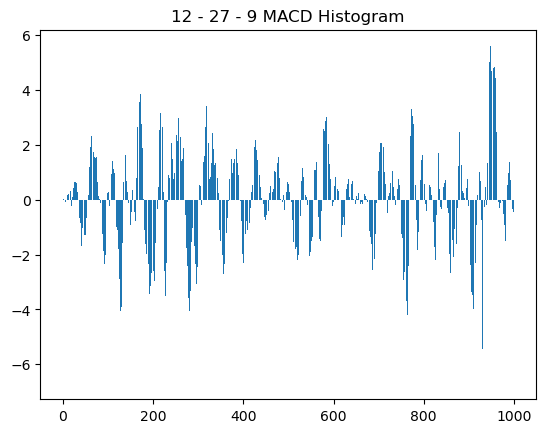

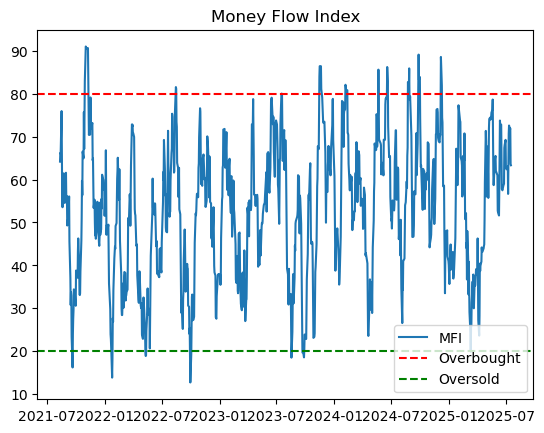

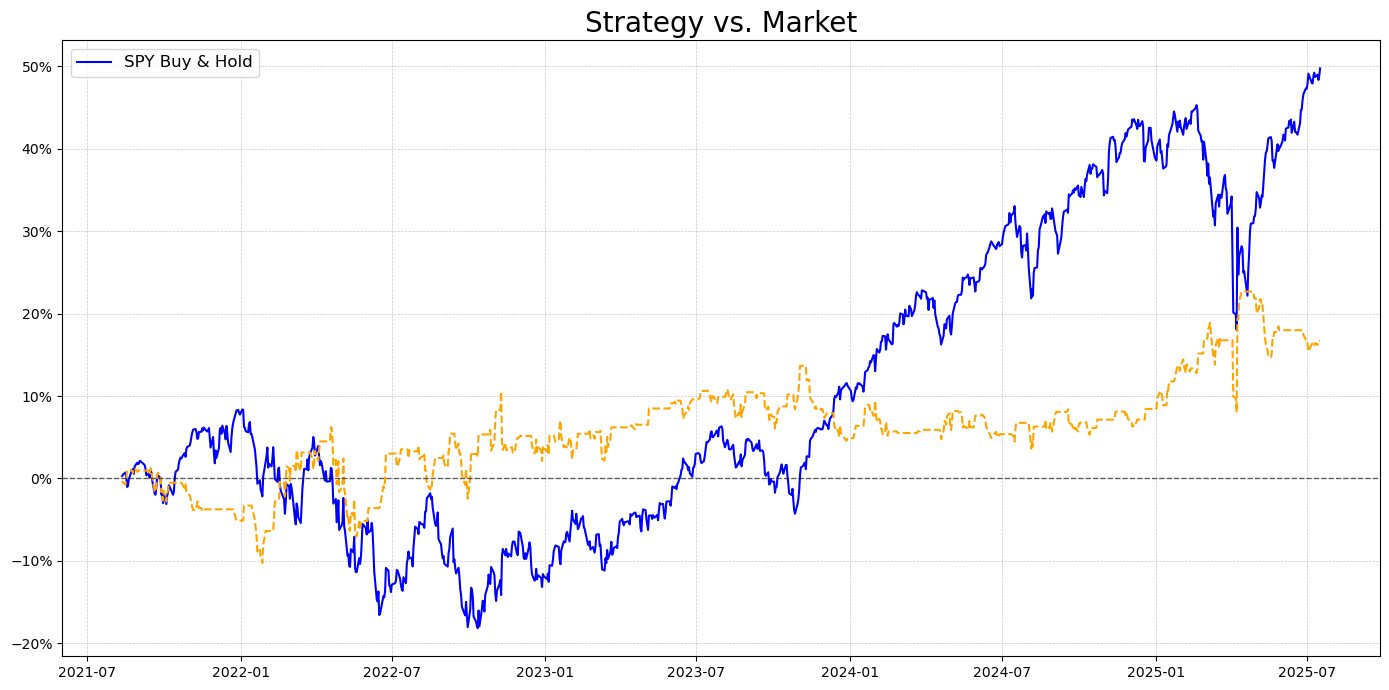

SPY Buy & Hold Return: 49.76%
SPY MACD/RSI Strategy Return over past 1000 days: 16.71%


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,...,Price_Change,Pos_Flow,Neg_Flow,MFI,MACD_Strategy,MFI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-11,419.366180,419.460685,418.269992,419.403988,44034300,417.197274,416.726278,0.470996,0.209406,0.261589,...,0.718158,1.845179e+10,0.000000e+00,64.171380,NaN,NaN,NaN,0,NaN,NaN
2021-08-12,420.623047,420.764818,418.307847,419.215026,38909400,417.771150,417.141109,0.630041,0.296601,0.333440,...,0.866285,1.633800e+10,0.000000e+00,66.189106,-1.0,-1.0,-2.0,-1,0.002997,-0.002997
2021-08-13,421.388458,421.407348,420.585214,421.076597,39470300,418.368938,417.577959,0.790979,0.398341,0.392639,...,1.228436,1.662201e+10,0.000000e+00,66.004639,-1.0,-1.0,-2.0,-1,0.004822,-0.004811
2021-08-16,422.380676,422.512959,418.506225,420.074907,73740000,419.024429,418.056881,0.967549,0.514805,0.452744,...,0.006280,3.105437e+10,0.000000e+00,75.941255,-1.0,-1.0,-2.0,-1,0.007188,-0.007155
2021-08-17,419.611908,420.481280,416.597398,419.800888,92673900,419.119512,418.207680,0.911832,0.595667,0.316165,...,-2.236425,0.000000e+00,3.882081e+10,64.696832,-1.0,-1.0,-2.0,-1,0.000586,-0.000646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-11,623.619995,624.859985,621.530029,622.739990,63670200,618.321665,608.116078,10.205587,9.922016,0.283572,...,-1.896667,0.000000e+00,3.968797e+10,72.575558,-1.0,-1.0,-2.0,-1,0.487054,0.164328
2025-07-14,624.809998,625.159973,621.799988,623.159973,51898500,619.319870,609.308501,10.011369,9.939886,0.071483,...,0.586650,3.238068e+10,0.000000e+00,71.645315,-1.0,-1.0,-2.0,-1,0.489891,0.162106
2025-07-15,622.140015,627.859985,622.059998,627.520020,74317300,619.753739,610.225038,9.528701,9.857649,-0.328948,...,0.096680,4.637548e+10,0.000000e+00,71.900986,-1.0,-1.0,-2.0,-1,0.483525,0.167072


In [70]:
def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_MACD_strategy(df)
    df = add_MFI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)
    return_summary(df, TICKER, LOOKBACK)  
    return df

main()